### Required imports

In [1]:
from sklearn.datasets import load_files

import numpy as np

import supporting_modules.text_cleaning as stc
import supporting_modules.data_visualization as sdv

## Load data from dataset

Firstly, we need to load the dataset for further analysis. In this case, it will be the dataset named **"Large Movie Review Dataset"**. It is downloaded from https://ai.stanford.edu/~amaas/data/sentiment/

The sentiment values in the text corpus from Stanford Dataset is either positive or negative. More info about these data is in `README` file. After loading, the data is of sklearn Bunch type, so we have to retrieve list of text data and numpy.ndarray with the labels.

In [2]:
train_data = load_files("../datasets/aclImdb_v1/aclImdb/train")
test_data = load_files("../datasets/aclImdb_v1/aclImdb/test")

reviews_train, y_train = train_data.data, train_data.target
reviews_test, y_test = test_data.data, test_data.target

The types of each data element are listed below. As we can see the data are saved as bytes. The length of the training data set is equal to 75,000. In the README file, it was mentioned that the quantity of positive and negative reviews is equal to 50,000 (per 25,000 in training and test part accordingly). The difference equal to 50,000 is caused by data labeled as 'unsup'. This part of the data includes an additional 50,000 unlabeled documents for unsupervised learning.

In the first part of the project, this data will not be needed. Therefore, they will be subtracted from the training pool (there is no data with this label in the test pool).

In [3]:
print(f"train_data data type: {type(train_data)}")
print(f"reviews_train type: {type(reviews_train)}")
print(f"the type of single review: {type(reviews_train[0])}")
print(f"reviews_test type: {type(reviews_test)}")
print(f"text_train data length: {len(reviews_train)}")
print(f"text_test data length: {len(reviews_test)}")

train_data data type: <class 'sklearn.utils._bunch.Bunch'>
reviews_train type: <class 'list'>
the type of single review: <class 'bytes'>
reviews_test type: <class 'list'>
text_train data length: 75000
text_test data length: 25000


In [4]:
# The data in the training set are distributed in the proportions of 12500, 12500, 50000
# In next steps I remove those items that are 'unsup', that is, without a clear indication

print(f"The proportions of the data distribution: {np.bincount(y_train)}")
print(f"Numeric values of labels: {np.unique(y_train, return_counts=True)}")
print(f"Label names: {train_data.target_names}\n")

print(f"The proportions of the data distribution: {np.bincount(y_test)}")
print(f"Numeric values of labels: {np.unique(y_test, return_counts=True)}")
print(f"Label names: {test_data.target_names}\n")

The proportions of the data distribution: [12500 12500 50000]
Numeric values of labels: (array([0, 1, 2]), array([12500, 12500, 50000]))
Label names: ['neg', 'pos', 'unsup']

The proportions of the data distribution: [12500 12500]
Numeric values of labels: (array([0, 1]), array([12500, 12500]))
Label names: ['neg', 'pos']



In [5]:
# lets see how the reviews looks like

print("POSITIVE REVIEW EXAMPLE:\n".upper(), reviews_train[3], "\n\n", "*" * 100, "\n")
print("NEGATIVE REVIEW EXAMPLE:\n", reviews_train[126])

POSITIVE REVIEW EXAMPLE:
 b"Dan Katzir has produced a wonderful film that takes us on a roller-coaster ride through a real romance set in the troubles surrounding modern Israel.<br /><br />For anyone who's ever been in love, the film brings back the uncertainties, the insecurities and heartache that make love so bitter-sweet. The atmosphere of fear and isolation that came with the difficult times in Israel at that time just serve to intensify the feeling. Instantly, you are drawn in to Dan's plight, and you can't fail to be deeply moved.<br /><br />You can't write drama and passion like this - the contrast between the realities of Dan's desperate, snatched relationship with Iris, and the realities of a state in turmoil make this eminently watchable. If you have an ounce of passion, and have ever been in love, see this film." 

 **************************************************************************************************** 

NEGATIVE REVIEW EXAMPLE:
 b"This film comes as the ultima

## Remove the data without labels

The data are cleaned using function defined in `additional_modules/test_cleaning`. 

After this action we'll have balanced binary data in both datasets (training and test). The data after applying stc.clear_reviews_from_dataset() function looks like:

In [6]:
reviews_train_binary, y_train_binary = stc.clear_reviews_from_dataset(y_train, reviews_train)

In [7]:
# Our data after applying stc.clear_reviews_from_dataset() function

print(f"The proportions of the data distribution: {np.bincount(y_train_binary)}")
print(f"Numeric values of labels: {np.unique(y_train_binary, return_counts=True)}")

The proportions of the data distribution: [12500 12500]
Numeric values of labels: (array([0, 1]), array([12500, 12500]))


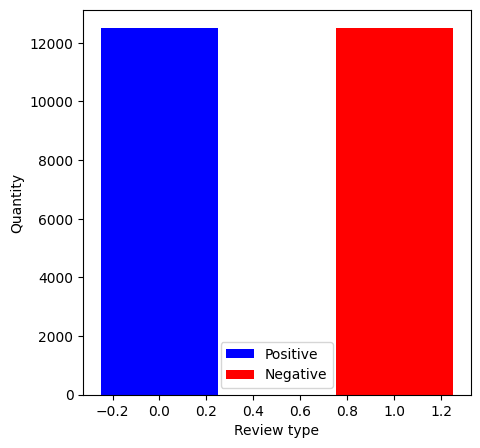

In [8]:
sdv.count_per_label(np.bincount(y_train_binary), ('Positive', 'Negative', 'Neutral'))

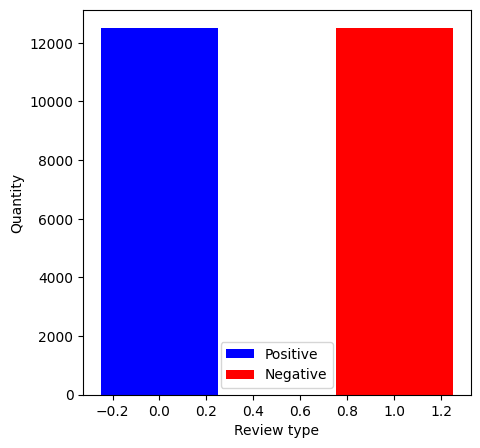

In [9]:
sdv.count_per_label(np.bincount(y_test), ('Positive', 'Negative', 'Neutral'))